**SESRec with Tensorflow**

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import precision_score, recall_score, f1_score

# Loading the train and test datasets
train_file = 'dataset/train_inter.tsv'
test_file = 'dataset/test_inter.tsv'

# Loading data from corresponding TSV files
train_data = pd.read_csv(train_file, sep='\t')
test_data = pd.read_csv(test_file, sep='\t')

# Data preprocessing and mapping to integer indices for metadata
train_data = train_data.dropna(subset=['rec_his', 'src_his', 'ts', 'label'])
test_data = test_data.dropna(subset=['rec_his', 'src_his', 'ts', 'label'])

X_train = train_data[['rec_his', 'src_his', 'ts']].values
y_train = train_data['label'].values

X_test = test_data[['rec_his', 'src_his', 'ts']].values
y_test = test_data['label'].values

# Building the recommender model with class weights and L2 regularization
model = keras.Sequential([
    keras.layers.Input(shape=(X_train.shape[1],)),  # Define input shape here
    keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1, activation='sigmoid')
])


# Configuring the optimizer with a learning rate scheduler
initial_learning_rate = 0.1
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100, decay_rate=0.9, staircase=True
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, clipvalue=1.0)

# Compiling the model with binary cross-entropy loss and class weights
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Implementing early stopping
early_stopping = keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True)

# Training the model with class weights
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Evaluating the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Binary crossentropy: {loss}")
print(f"Test Accuracy: {accuracy}")

# Making predictions on the test set
y_pred = model.predict(X_test)
integer_predictions = [1 if prediction >= 0.5 else 0 for prediction in y_pred]

# Calculating precision, recall, and F1 score
precision = precision_score(y_test, integer_predictions)
recall = recall_score(y_test, integer_predictions)
f1 = f1_score(y_test, integer_predictions)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Recommendations for a user as per the user history rec_his
user = X_test[0:1]
predictions = model.predict(user)
user_integer_predictions = [1 if prediction >= 0.5 else 0 for prediction in predictions]
print(f"Recommendations for the user: {user_integer_predictions}")

**CODE WITH WITH ADDED ATTENTION LAYER, MATRIX FACTORIZATION (SINGULAR VALUE DECOMPOSITION) AND NEUTRAL COLLABORATIVE FILTERING(NCF)**

<ipython-input-5-3ea8e54d244d>:20: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  train_data = pd.read_csv(train_file, sep='\t', error_bad_lines=False)
<ipython-input-5-3ea8e54d244d>:21: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  test_data = pd.read_csv(test_file, sep='\t', error_bad_lines=False)
<ipython-input-5-3ea8e54d244d>:67: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  num_users = len(pd.unique(train_data['u_id'].append(test_data['u_id'])))
<ipython-input-5-3ea8e54d244d>:68: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  num_items = len(pd.unique(train_data['i_id'].append(test_data['i_id'])))


Epoch 1/10
18565/18565 [==============================] - 96s 5ms/step - loss: 0.3690 - accuracy: 0.9994 - val_loss: 0.1331 - val_accuracy: 1.0000
Epoch 2/10
18565/18565 [==============================] - 71s 4ms/step - loss: 0.3677 - accuracy: 1.0000 - val_loss: 0.1347 - val_accuracy: 1.0000
Epoch 3/10
18565/18565 [==============================] - 65s 4ms/step - loss: 0.3678 - accuracy: 1.0000 - val_loss: 0.1336 - val_accuracy: 1.0000
Epoch 4/10
18565/18565 [==============================] - 63s 3ms/step - loss: 0.3679 - accuracy: 1.0000 - val_loss: 0.1343 - val_accuracy: 1.0000
Epoch 5/10
18565/18565 [==============================] - 66s 4ms/step - loss: 0.3676 - accuracy: 1.0000 - val_loss: 0.1332 - val_accuracy: 1.0000
Epoch 6/10
18565/18565 [==============================] - 66s 4ms/step - loss: 0.3677 - accuracy: 1.0000 - val_loss: 0.1340 - val_accuracy: 1.0000
Epoch 7/10
18565/18565 [==============================] - 66s 4ms/step - loss: 0.3678 - accuracy: 1.0000 - val_loss: 0

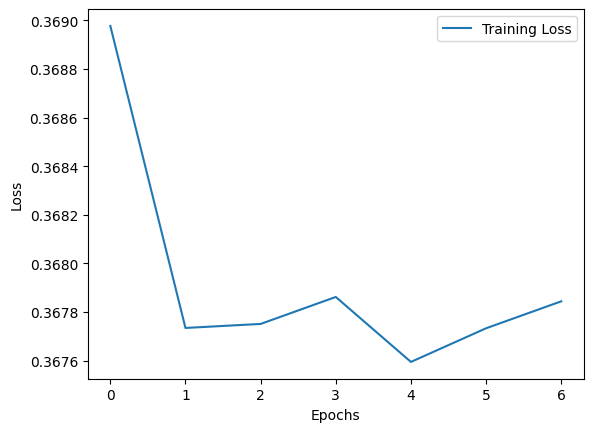

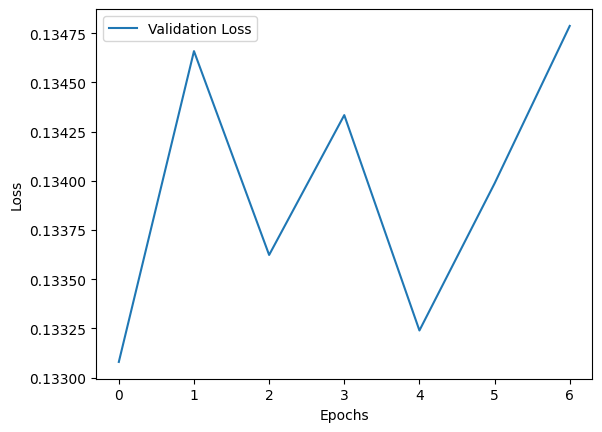

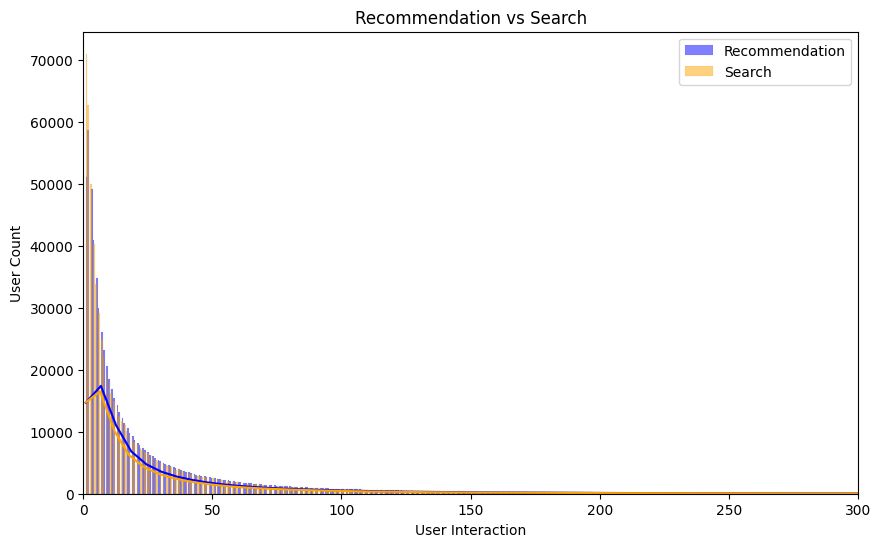

In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.decomposition import TruncatedSVD
from fastFM import sgd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Loading the train and test datasets
train_file = 'train_inter.tsv'
test_file = 'test_inter.tsv'

# Loading data from corresponding TSV files
train_data = pd.read_csv(train_file, sep='\t', error_bad_lines=False)
test_data = pd.read_csv(test_file, sep='\t', error_bad_lines=False)

# Data preprocessing and mapping to integer indices for metadata
train_data = train_data.dropna(subset=['rec_his', 'src_his', 'ts', 'label'])
test_data = test_data.dropna(subset=['rec_his', 'src_his', 'ts', 'label'])

X_train = train_data[['rec_his', 'src_his', 'ts']].values
y_train = train_data['label'].values

X_test = test_data[['rec_his', 'src_his', 'ts']].values
y_test = test_data['label'].values

# Defining the attention layer
class AttentionLayer(keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W_q = self.add_weight(name='W_q',
                                  shape=(input_shape[-1], input_shape[-1]),
                                  initializer='uniform',
                                  trainable=True)
        self.W_k = self.add_weight(name='W_k',
                                  shape=(input_shape[-1], input_shape[-1]),
                                  initializer='uniform',
                                  trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        q = tf.matmul(x, self.W_q)
        k = tf.matmul(x, self.W_k, transpose_b=True)
        v = x

        attn_scores = tf.matmul(q, k, transpose_b=True)
        attn_scores = tf.nn.softmax(attn_scores)
        output = tf.matmul(attn_scores, v)

        return output

# Matrix Factorization (SVD)
svd = TruncatedSVD(n_components=1, random_state=42)  # Adjust the number of components
X_train_svd = svd.fit_transform(X_train)
X_test_svd = svd.transform(X_test)

# Determining the number of unique users and items in the dataset
num_users = len(pd.unique(train_data['u_id'].append(test_data['u_id'])))
num_items = len(pd.unique(train_data['i_id'].append(test_data['i_id'])))

# Neural Collaborative Filtering (NCF)
user_input = keras.layers.Input(shape=(1,))
item_input = keras.layers.Input(shape=(1,))
user_embedding_layer = keras.layers.Embedding(input_dim=num_users, output_dim=50, input_length=1)
item_embedding_layer = keras.layers.Embedding(input_dim=num_items, output_dim=50, input_length=1)
user_embedding = user_embedding_layer(user_input)
item_embedding = item_embedding_layer(item_input)
merged = keras.layers.Dot(axes=1)([user_embedding, item_embedding])
ncf_output = keras.layers.Dense(1, activation='sigmoid')(merged)
ncf_model = keras.Model(inputs=[user_input, item_input], outputs=ncf_output)

# Building the recommender model with class weights and L2 regularization
model = keras.Sequential([
    keras.layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    keras.layers.BatchNormalization(),
    AttentionLayer(),
    keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid')
])

# Configuring the optimizer with a learning rate scheduler
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100, decay_rate=0.01, staircase=True
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, clipvalue=1.0)

# Compiling the model with binary cross-entropy loss and class weights
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Implementing early stopping
early_stopping = keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True)

# Training the model with class weights
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Evaluating the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Binary crossentropy: {loss}")
print(f"Test Accuracy: {accuracy}")

# Making predictions on the test set
y_pred = model.predict(X_test)
integer_predictions = [1 if prediction >= 0.5 else 0 for prediction in y_pred]

# Calculating precision, recall, and F1 score
precision = precision_score(y_test, integer_predictions)
recall = recall_score(y_test, integer_predictions)
f1 = f1_score(y_test, integer_predictions)


# Recommendations for a user as per the user history rec_his
user = X_test[0:1]
predictions = model.predict(user)
user_integer_predictions = [1 if prediction >= 0.5 else 0 for prediction in predictions]
print(f"Recommendations for the user: {user_integer_predictions}")


# Display the metrics table
metrics_data = {'Metric': ['Precision', 'Recall', 'F1 Score'],
                'Value': [precision, recall, f1]}
metrics_df = pd.DataFrame(metrics_data)

print(metrics_df)
print("\n")
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
print("\n")
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
print("\n")

plt.figure(figsize=(10, 6))
sns.histplot(data=train_data, x='rec_his', kde=True, color='blue', label='Recommendation')
sns.histplot(data=train_data, x='src_his', kde=True, color='orange', label='Search')
plt.xticks(range(0, 301, 50))
plt.xlim(0, 300)
plt.title('Recommendation vs Search')
plt.xlabel('User Interaction')
plt.ylabel('User Count')
plt.legend()
plt.show()